In [38]:
from pathlib import Path
import re
import time
from random import choices

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial import distance
from scipy.spatial import distance
from scipy.stats import norm
import seaborn as sns

class Tile:
    
    def __init__(self, minx, maxx, miny, maxy, data):
        
        self.minx = minx
        self.maxx = maxx
        self.miny = miny
        self.maxy = maxy
        self.data = data
        
        self.area = (maxx-minx)*(maxy-miny)
        
        self.ncells = len(data)
        self.count_cells_by_celltype()
    
    def count_cells_by_celltype(self):
        
        counts = data['Class'].value_counts()
        
        for ct in set(data['Class'].values):
            
            setattr(self, 'count_'+ct, counts[ct])
            setattr(self, 'fraction_'+ct, counts[ct]/len(data))
            setattr(self, 'density_'+ct, counts[ct]/self.area)
    
    def tile_enrichment(self):
        
        self.close_num_dict = spatial_enrichment(self.data)
        
        for k in self.close_num_dict.keys():
            setattr(self, k, self.close_num_dict[k])
            
def tile_dict_to_dataframe(tiles, cell_types):
    
    rows = []
    cols = []
    minx = []
    maxx = []
    miny = []
    maxy = []
    area = []
    
    ncells = []
    
    fraction_dict = {}
    counts_dict = {}
    density_dict = {}
    interactions_dict = {}
    
    ct_ct_pairs_done = []
    
    for ct in cell_types:
        fraction_dict["fraction_" + ct] = []
        counts_dict["count_" + ct] = []
        density_dict["density_" + ct] = []
        
        for ct2 in cell_types:
            if ((ct,ct2) not in ct_ct_pairs_done) and (ct != 'other') and (ct2 != 'other'):
                interactions_dict[ct + "_" + ct2 + "_interactions"] = []
                ct_ct_pairs_done.append((ct,ct2))
    
    for pos,tile in tiles.items():
        
        rows.append(pos[0])
        cols.append(pos[1])
        
        ncells.append(tile.ncells)
        minx.append(tile.minx)
        maxx.append(tile.maxx)
        miny.append(tile.miny)
        maxy.append(tile.maxy)
        area.append(tile.area)
        
        for fk in fraction_dict.keys():
            
            try:
                fraction_dict[fk].append(getattr(tile,fk))
            except AttributeError:
                fraction_dict[fk].append(0)
        
        for ck in counts_dict.keys():
            try:
                counts_dict[ck].append(getattr(tile,ck))
            except AttributeError:
                counts_dict[ck].append(0)
        
        for dk in density_dict.keys():
            try:
                density_dict[dk].append(getattr(tile,dk))
            except AttributeError:
                density_dict[dk].append(0)
        
        for ik in interactions_dict.keys():
            try:
                interactions_dict[ik].append(getattr(tile,ik))
            except AttributeError:
                interactions_dict[ik].append(0)
                
    results = {"row":rows,
               "col":cols,
               "ncells":ncells,
               "minx":minx,
               "maxx":maxx,
               "miny":miny,
               "maxy":maxy,
               "area":area}
    
    results.update(fraction_dict)
    results.update(counts_dict)
    results.update(density_dict)
    results.update(interactions_dict)
    
    return pd.DataFrame(data=results)

# TODO:
#def dataframe_to_tiles(data):

def expression_scatter(data, ct, channels, savepath):

    fig = plt.figure(figsize=(10,10))
    fig.patch.set_facecolor('white')

    ch1 = channels[0] + ": Cell: Mean"
    ch2 = channels[1] + ": Cell: Mean"
    
    if len(ct) == 1:

        pos = data[data['Class']==ct[0]]
        neg = data[data['Class']!=ct[0]]
        
        plt.scatter(np.log10(neg[ch1]),np.log10(neg[ch2]),color=[0,0,0],alpha=0.2)
        plt.scatter(np.log10(pos[ch1]),np.log10(pos[ch2]),color=np.array([27,158,119])/255,alpha=0.4)
        plt.xlabel("log("+ch1+ " Mean Cell Expression)")
        plt.ylabel("log("+ch2+ " Mean Cell Expression)")

        plt.legend(["not "+ct[0], ct[0]])
        
    elif len(ct) == 2:

        pos = data[data['Class']==ct[0]]
        pos2 = data[data['Class']==ct[1]]
        neg = data[np.logical_and(data['Class']!=ct[0],data['Class']!=ct[1])]

        plt.scatter(np.log10(neg[ch1]),np.log10(neg[ch2]),color=[0,0,0],alpha=0.2)
        plt.scatter(np.log10(pos[ch1]),np.log10(pos[ch2]),color=np.array([27,158,119])/255,alpha=0.4)
        plt.scatter(np.log10(pos2[ch1]),np.log10(pos2[ch2]),color=np.array([117,112,179])/255,alpha=0.4)

        plt.xlabel("log("+ch1+ " Mean Cell Expression)")
        plt.ylabel("log("+ch2+ " Mean Cell Expression)")
    
        plt.legend(["other", ct[0], ct[1]])
    

    figpath = Path(savepath, "_".join(ct) + "_expression.png")
    
    plt.savefig(figpath,
                facecolor=fig.get_facecolor(),
                bbox_inches='tight',
                transparent=False)
    plt.close('all')
    
def map_frequencies_to_image(data, cell_type, figpath):
    
    fig = plt.figure(figsize=(15,15))
    fig.patch.set_facecolor('white')
    counts = []
    for row in data.iterrows():
        X = (row[1]['minx'] + row[1]['maxx'])/2
        Y = (row[1]['miny'] + row[1]['maxy'])/2
        
        count = row[1]['count_'+cell_type]
        counts.append(count)
        sc = plt.scatter(X,Y,s=count,color='b')
    
    
    for area in [np.round(x) for x in np.logspace(1,np.round(np.log10(np.max(counts))),5)]:
        plt.scatter([], [], c='k', alpha=0.3, s=area,
                    label=str(area))
        
    plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='# of '+cell_type, loc='upper right')
    
    plt.savefig(figpath,
                facecolor=fig.get_facecolor(),
                bbox_inches='tight',
                transparent=False)
    plt.close('all')
    
def tile_differences(tiles, cell_types):
    
    diff = {}
    
    for ct in cell_types:
        
        diff[ct] = []
        done = []
        
        for pos in tiles.keys():
            
            center_tile = tiles[pos]
            ci=pos[0]
            cj=pos[1]
            
            for i in [ci-1, ci, ci+1]:
                for j in [cj-1, cj, cj+1]:
                    
                    # Don't count difference between tile and itself
                    # and don't count differences more than once
                    
                    if ((i==ci) and (j==cj)) or ([ci, cj, i, j] in done): continue
                    
                    try:
                        
                        current_tile_count = 0
                        neighbor_tile_count = 0
                        
                        try:

                            current_tile_count = getattr(tiles[ci,cj],'count_'+ct)
                        except AttributeError:
                            pass

                        try:

                            neighbor_tile_count = getattr(tiles[i,j],'count_'+ct)
                        except AttributeError:
                            pass
                        
                        diff[ct].append(np.abs(current_tile_count - neighbor_tile_count))
                        done.append([ci, cj, i, j])
                    except KeyError: pass
            
    return diff

def plot_frequency_histograms(data_dict, tile_dict, cell_types, window_sizes, sample_results_dir, sample_name):    
    
    for ct in cell_types:
        
        fig,ax = plt.subplots(nrows=len(window_sizes),figsize=(10,5),sharex=True)
        
        fig.patch.set_facecolor('white')
        
        if len(window_sizes) == 1:
            ws = window_sizes[0]
            data = data_dict[ws]
            sns.histplot(ax=ax, x=data["count_"+ct], bins=20)
            ax.set_ylabel('')
            ax.set_title("window size = "+str(ws))

        else:
            
            for i,ws in enumerate(window_sizes):
                data = data_dict[ws]
                sns.histplot(ax=ax[i], x=data["count_"+ct], bins=20)
                ax[i].set_ylabel('')
                ax[i].set_title("window size = "+str(ws))
            
        fig.suptitle(sample_name + ": " + ct + " frequency over tiles")
        plt.ylabel('Number of tiles')
        plt.xlabel('Number of cells')
        
        figpath = Path(sample_results_dir, ct + "_frequency_hist.png")
        plt.savefig(figpath,
            facecolor=fig.get_facecolor(),
            bbox_inches='tight',
            transparent=False)
        
        plt.close('all')
        
        fig,ax = plt.subplots(nrows=len(window_sizes), figsize=(10,5),sharex=True)
        fig.patch.set_facecolor('white')

        if len(window_sizes) == 1:
            ws = window_sizes[0]
            data = data_dict[ws]
            sns.histplot(ax=ax, x=data["fraction_"+ct], bins=20)
            ax.set_ylabel('')
            ax.set_title("window size = "+str(ws))
        else:
            for i,ws in enumerate(window_sizes):
                data = data_dict[ws]
                sns.histplot(ax=ax[i], x=data["fraction_"+ct], bins=20)
                ax[i].set_ylabel('')
                ax[i].set_title("window size = "+str(ws))
            
        fig.suptitle(sample_name + ": " + ct + " fraction over tiles")
        plt.ylabel('Number of tiles')
        plt.xlabel('Fraction ' + ct +"/all cells")
        
        figpath = Path(sample_results_dir, ct + "_fraction_hist.png")
        plt.savefig(figpath,
            facecolor=fig.get_facecolor(),
            bbox_inches='tight',
            transparent=False)
        
        plt.close('all')
        
        fig,ax = plt.subplots(nrows=len(window_sizes), figsize=(10,5),sharex=True)
        fig.patch.set_facecolor('white')
        if len(window_sizes) == 1:
            ws = window_sizes[0]
            data = data_dict[ws]
            sns.histplot(ax=ax, x=data["density_"+ct], bins=20)
            ax.set_ylabel('')
            ax.set_title("window size = "+str(ws))

        else:
            for i,ws in enumerate(window_sizes):
                data = data_dict[ws]
                sns.histplot(ax=ax[i], x=data["density_"+ct], bins=20)
                ax[i].set_ylabel('')
                ax[i].set_title("window size = "+str(ws))

        fig.suptitle(sample_name + ": " + ct + " density over tiles")
        plt.ylabel('Number of tiles')
        plt.xlabel('# cells/um^{2}')
        
        figpath = Path(sample_results_dir, ct + "_density_hist.png")
        plt.savefig(figpath,
            facecolor=fig.get_facecolor(),
            bbox_inches='tight',
            transparent=False)
        
        plt.close('all')
        
        for ws in window_sizes:
            
            figpath = Path(sample_results_dir, "tiled_"+ct + "_window_size_"+str(ws)+".png")
            map_frequencies_to_image(data, ct, figpath)
            plt.close('all')
            
        for i,ws in enumerate(window_sizes):
            
            data = data_dict[ws]
            for ct2 in cell_types:
                
                if ct == ct2: continue
                
                fig = plt.figure(figsize=(5,5))
                fig.patch.set_facecolor('white')
                
                plt.scatter(data["count_"+ct], data["count_"+ct2])
                plt.title(sample_name + ", " + "window size = " + str(ws))
                
                plt.xlabel("# "+ ct)
                plt.ylabel("# "+ ct2)
                
                figpath = Path(sample_results_dir, ct + "_" + ct2 + "_" + "ws"+str(ws)+"_corr_plot.png")
                plt.savefig(figpath,
                    facecolor=fig.get_facecolor(),
                    bbox_inches='tight',
                    transparent=False)
        plt.close('all')
        diff = {}
        
        for ws in window_sizes:
            
            diff[ws] = tile_differences(tile_dict[ws], cell_types)
        
            
        fig,ax = plt.subplots(nrows=len(window_sizes), figsize=(10,5),sharex=True)
        fig.patch.set_facecolor('white')
        
        if len(window_sizes) == 1:
            ws = window_sizes[0]
            d = diff[ws]

            sns.histplot(ax=ax, x=d[ct], bins=20)
            ax.set_ylabel('')
            ax.set_title("window size = "+str(ws))

        else:
            for i,ws in enumerate(window_sizes):

                d = diff[ws]

                sns.histplot(ax=ax[i], x=d[ct], bins=20)
                ax[i].set_ylabel('')
                ax[i].set_title("window size = "+str(ws))
            
        fig.suptitle(sample_name + ": " + ct + " differences between tiles")
        plt.ylabel('# of tile pairs')
        plt.xlabel('difference in # cells between adjacent tiles')
        
        figpath = Path(sample_results_dir, ct + "_diff_hist.png")
        plt.savefig(figpath,
            facecolor=fig.get_facecolor(),
            bbox_inches='tight',
            transparent=False)
        
        plt.close('all')
        
def spatial_enrichment(data, distance_threshold=10):

    # Input: dataframe with single cell entries (incl x,y,class)
    
    ncells=len(data)

    cell_types = list(set(data['Class']))
    
    try:
        cell_types.remove('other')
    except ValueError:
        pass
    
    ncell_types = len(cell_types)

    bootstrap_num = 1000
    
    centroid_coords = np.stack([data['Centroid X µm'],
                                data['Centroid Y µm']]).astype(np.float32).transpose()
    
    
    dist_mat = distance.cdist(centroid_coords, centroid_coords, metric="euclidean").astype(np.float32)
    
    bin_dist_mat = dist_mat<distance_threshold
    
    close_num = np.zeros((ncell_types, ncell_types), dtype=np.uint64)
    close_rand = np.zeros((ncell_types, ncell_types, bootstrap_num), dtype=np.uint64)

    for i in np.arange(ncell_types):

        ct1_pos_inds = (data['Class']==cell_types[i])
        n_ct1 = sum(ct1_pos_inds)

        for j in np.arange(ncell_types):

            ct2_pos_inds = (data['Class']==cell_types[j])
            n_ct2 = sum(ct2_pos_inds)

            grid = np.ix_(ct1_pos_inds, ct2_pos_inds)
            close_num[i, j] += np.sum(bin_dist_mat[grid])
    '''     
            for r in np.arange(bootstrap_num):
                ct1_rand_inds = np.random.choice(np.arange(ncells), size=n_ct1, replace=True)
                ct2_rand_inds = np.random.choice(np.arange(ncells), size=n_ct2, replace=True)

                grid = np.ix_(ct1_rand_inds, ct2_rand_inds)
                close_rand[i, j, r] += np.sum(bin_dist_mat[grid])
     
    z = np.zeros((ncell_types,ncell_types))
    muhat = np.zeros((ncell_types,ncell_types))
    sigmahat = np.zeros((ncell_types,ncell_types))
    p = np.zeros((ncell_types, ncell_types, 2))
    
    for j in np.arange(ncell_types):
        for k in np.arange(ncell_types):

            mu, sigma = norm.fit(close_rand[j,k,:])
            muhat[j,k]=mu
            sigmahat[j,k]=sigma

            z[j,k] = (close_num[j,k]-muhat[j,k])/sigmahat[j,k]
            p[j,k,0] = (1+(sum(close_rand[j,k,:]>=close_num[j,k])))/(bootstrap_num+1)
            p[j,k,1] = (1+(sum(close_rand[j,k,:]<=close_num[j,k])))/(bootstrap_num+1)

    # adjust p-values using FDR 0.05 (Inf or NaN will have p value 1)
    p_summary = p[:,:,1];
    for j in np.arange(ncell_types):
        for k in np.arange(ncell_types):
            # if interaction is enriched +z grab first p-value
            if (z[j,k] > 0):
                p_summary[j,k] = p[j,k,0];
            # if interaction is avoided -z grab second p-value
            elif (z[j,k] < 0):
                p_summary[j,k] = p[j,k,1];
       
    #h, crit_p, adj_ci_cvrg, adj_p = mt(p_summary, alpha=0.05, method='fdr_bh')
    
    z_dict = {}
    '''
    close_num_dict = {}
    
    for cti in np.arange(ncell_types):
        for ctj in np.arange(ncell_types):
            
            #z_dict[cell_types[cti]+ "_" + cell_types[ctj]+"_z"] = z[cti,ctj]
            close_num_dict[cell_types[cti]+"_"+cell_types[ctj]+"_interactions"] = close_num[cti,ctj]
    #return z_dict, close_num_dict
    return close_num_dict

def summarize_tiles(data, cell_types):
    
    summary = {}
    summary['area'] = np.sum(data['area'])
    
    summary['ncells'] = np.sum(data['ncells'])
    
    for ct1 in cell_types:
        
        ct1_hf = data['fraction_'+ct1]>0.05
        
        # number of high frequency tiles
        summary[ct1 + '_hf_tiles'] = np.sum(ct1_hf)
        summary[ct1 + '_hf_tiles_fraction'] = np.sum(ct1_hf)/len(data)
        
        for ct2 in cell_types:
            
            try:
                summary[ct1 + "_" + ct2 + "_interactions_count"] = np.sum(data[ct1 + "_" + ct2 + "_interactions"])
            except KeyError:
                pass
            
            if ct1==ct2: continue
                
            ct2_hf = data['fraction_'+ct2]>0.05
            coloc = np.sum(np.logical_and(ct1_hf, ct2_hf))
            summary[ct1 + "_" + ct2 + "_bias"] = (np.sum(ct1_hf) + np.sum(ct2_hf))/coloc
        
    return summary

In [39]:
cell_types = ['cd163_pos_haldr_neg',
              'cd4_t_cell',
              'cd8_t_cell',
              'cdc1',
              'double_neg_t_cell',
              'double_pos_t_cell',
              'mac' ,
              'other',
              'other_myeloid_and_b_cells',
              'xcr1_cd163_double_pos']

In [41]:
datadir = Path("F:/ucsf/bidc/IPI/data/qupath_output/20221031/")
arch_filepath = Path("F:/ucsf/bidc/IPI/data/ipi_archetypes.csv")
results_dir = Path("F:/ucsf/bidc/IPI/data/qupath_output/tiled_frequency_results")

archetypes = pd.read_csv(arch_filepath, header=0)

arch_dict = {}

for row in archetypes.iterrows():
    sample = row[1]['sample'].split(".")[0]
    arch_dict[sample] = row[1]['archetype']
    
class_channels = [(['cd4_t_cell'],['CD3','CD4']),
                  (['cd8_t_cell'],['CD3','CD8']),
                  (['cdc1'],['XCR1','HLADR']),
                  (['double_neg_t_cell'],['CD4','CD8']),
                  (['double_pos_t_cell'],['CD4','CD8']),
                  (['mac'],['HLADR','CD163']),
                  (['other_myeloid_and_b_cells'],['HLADR','CD3']),
                  (['xcr1_cd163_double_pos'],['CD163','XCR1']),
                  (['cd163_pos_haldr_neg'],['CD163','HLADR']),
                  (['cd4_t_cell','cd8_t_cell'],['CD4','CD8'])]

do_plot = False
do_spatial_enrichment = False

summary = {}
summary['sample'] = []
summary['archetype'] = []
#summary['area'] = []

for ct1 in cell_types:
    
    summary[ct1 + '_hf_tiles'] = []
    summary[ct1 + '_hf_tiles_fraction'] = []
    summary['fraction_' + ct1] = []
    summary['fraction_tumor_' + ct1] = []
    summary['fraction_stroma_' + ct1] = []
    summary['count_' + ct1] = []
    summary['count_tumor_' + ct1] = []
    summary['count_stroma_' + ct1] = []
    
    for ct2 in cell_types:
        #if (ct1 != 'other') and (ct2 !='other'):
        #    summary[ct1 + "_" + ct2 + "_interactions_count"] = []
        if ct1==ct2: continue
        summary[ct1 + "_" + ct2 + "_bias"] = []

for f in datadir.glob("*csv"):
    
    if not results_dir.exists():
        results_dir.mkdir()
    
    sample_name = re.match("IPI[A-Z]*[0-9]*",f.stem)[0]
    print(sample_name)
    sample_results_dir = Path(results_dir, sample_name)
    
    if not sample_results_dir.exists():
        sample_results_dir.mkdir()
    
    df = pd.read_csv(f)
    if len(df) < 2:
        continue

    stroma_idx = df['Parent']=='Image'
    df.loc[stroma_idx, 'Parent']='Stroma'
    
    # Plot expression scatter for QC
    
    if do_plot:    
        for k,v in class_channels:
            
            expression_scatter(df, k, v, sample_results_dir)
    
    X = df['Centroid X µm'].values
    Y = df['Centroid Y µm'].values

    minX = np.min(X)
    minY = np.min(Y)
    maxX = np.max(X)
    maxY = np.max(Y)

    window_sizes = [100]
    
    n_cell_types = len(cell_types)

    z_scores = np.empty((n_cell_types, n_cell_types))
    z_scores[:] = np.nan
    
    data_dict = {}
    
    #initialize tile_dict
    tile_dict = {}
    
    for ws in window_sizes:

        tile_dict[ws] = {}
        
        row = 0
        col = 0
        
        for i in np.arange(minX,maxX,ws):
            
            for j in np.arange(minY,maxY,ws):

                data = df.loc[(df['Centroid X µm']>=i) &
                              (df['Centroid X µm']<i+ws) &
                              (df['Centroid Y µm']>=j) &
                              (df['Centroid Y µm']<j+ws)]
                
                if len(data) > 2:
                    tile_dict[ws][row,col] = Tile(np.min(data['Centroid X µm']),
                                                  np.max(data['Centroid X µm']),
                                                  np.min(data['Centroid Y µm']),
                                                  np.max(data['Centroid Y µm']),
                                                  data)
                    if do_spatial_enrichment:
                        tile_dict[ws][row,col].tile_enrichment()
                   
                col +=1
            row+=1
            col=0
        
        data_dict[ws] = tile_dict_to_dataframe(tile_dict[ws], cell_types)
        data_dict[ws].to_csv(Path(sample_results_dir, sample_name + "_" + str(ws)+"_tile_data.csv"))
        
    if do_plot:
        plot_frequency_histograms(data_dict,
                                  tile_dict,
                                  ['cd4_t_cell', 'cd8_t_cell','cdc1','mac'],
                                  window_sizes,
                                  sample_results_dir,
                                  sample_name)
    
    
    sample_summary = summarize_tiles(data_dict[100], cell_types)
    
    
    summary['sample'].append(sample_name)
    try:
        summary['archetype'].append(arch_dict[sample_name])
    except KeyError:
        summary['archetype'].append('None')
        
    #summary['area'].append(sample_summary['area'])

    for ct1 in cell_types:
        
        try:
            summary[ct1 + '_hf_tiles'].append(sample_summary[ct1 + '_hf_tiles'])
        except KeyError:
            summary[ct1 + '_hf_tiles'].append(0)
        
        try:
            summary[ct1 + '_hf_tiles_fraction'].append(sample_summary[ct1 + '_hf_tiles_fraction'])
        except KeyError:
            summary[ct1 + '_hf_tiles_fraction'].append(0)
            
        for ct2 in cell_types:
            
            #if (ct1 != 'other') and (ct2 !='other'):
           # 
           #     try:
           #         summary[ct1+"_"+ct2+"_interactions_count"].append(sample_summary[ct1+"_"+ct2+"_interactions_count"])
           #     except KeyError:
           #         summary[ct1+"_"+ct2+"_interactions_count"].append(0)

            if ct1==ct2: continue
            
            try:
                summary[ct1 + "_" + ct2 + "_bias"].append(sample_summary[ct1 + "_" + ct2 + "_bias"])
            except KeyError:
                summary[ct1 + "_" + ct2 + "_bias"].append(0)
        
        summary['fraction_' + ct1].append(len(df[df['Class']==ct1])/len(df))
        summary['count_' + ct1].append(len(df[df['Class']==ct1]))
        
        summary['count_tumor_' + ct1].append(len(df[np.logical_and(df['Class']==ct1, df['Parent']=='Tumor')]))
        if len(df[df['Parent']=='Tumor'])==0:
            summary['fraction_tumor_'+ct1].append(0)
        else:
            summary['fraction_tumor_' + ct1].append(len(df[np.logical_and(df['Class']==ct1, df['Parent']=='Tumor')])/len(df[df['Parent']=='Tumor']))
            
        summary['count_stroma_' + ct1].append(len(df[np.logical_and(df['Class']==ct1, df['Parent']=='Stroma')]))            
        
        if len(df[df['Parent']=='Stroma'])==0:
            summary['fraction_stroma_'+ct1].append(0)
        else:
            summary['fraction_stroma_' + ct1].append(len(df[np.logical_and(df['Class']==ct1, df['Parent']=='Stroma')])/len(df[df['Parent']=='Stroma']))

    summary_df = pd.DataFrame(data=summary)
    summary_df.to_csv(Path(sample_results_dir.parent, "summarized_data.csv"))            
    break

IPIBLAD013


C:\Users\edwardsa\AppData\Local\Temp\ipykernel_21964\2012257929.py:520: RuntimeWarning: divide by zero encountered in longlong_scalars
  summary[ct1 + "_" + ct2 + "_bias"] = (np.sum(ct1_hf) + np.sum(ct2_hf))/coloc
C:\Users\edwardsa\AppData\Local\Temp\ipykernel_21964\2012257929.py:520: RuntimeWarning: invalid value encountered in longlong_scalars
  summary[ct1 + "_" + ct2 + "_bias"] = (np.sum(ct1_hf) + np.sum(ct2_hf))/coloc


0.0

In [401]:
cd8_cdc1_interactions = summary_df['cd8_t_cell_cdc1_interactions_count'].values/summary_df['area'].values
cd8_cd4_interactions = summary_df['cd4_t_cell_cd8_t_cell_interactions_count'].values/summary_df['area'].values

/tmp/ipykernel_2152528/285538979.py:2: RuntimeWarning: divide by zero encountered in log
  sns.scatterplot(np.log(cd8_cdc1_interactions), np.log(cd8_cd4_interactions),
/home/austin/miniconda3/envs/workshop/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

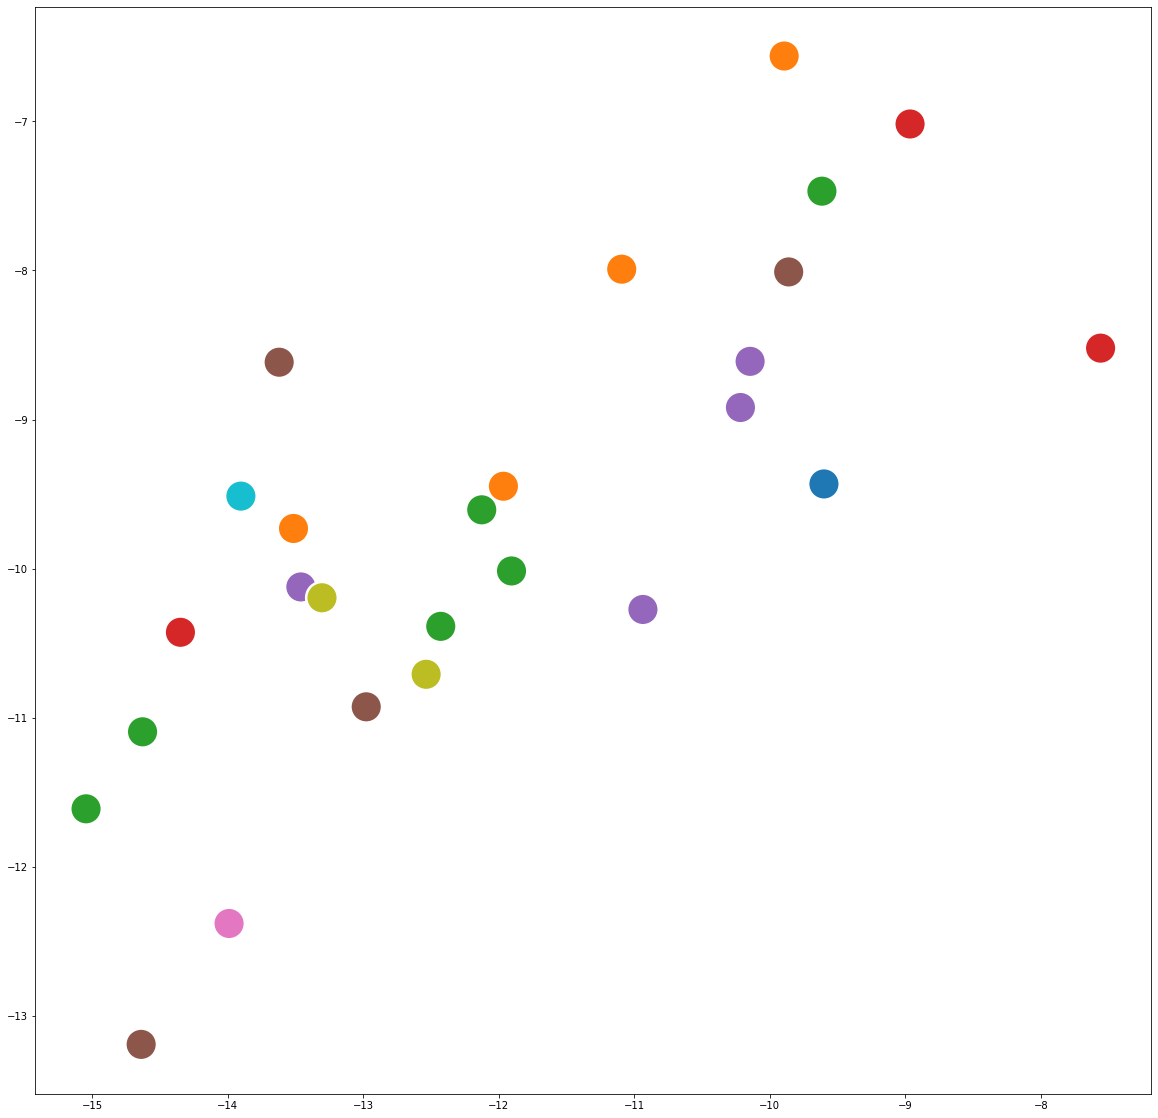

In [405]:
f = plt.figure(figsize=(20,20))
sns.scatterplot(np.log(cd8_cdc1_interactions), np.log(cd8_cd4_interactions),
                hue=summary_df['archetype'],
                s=1000,
                legend=False)


In [45]:
datadir = Path("/home/austin/data/IPI/tiled_frequency_results/")
data_list = []
for d in datadir.iterdir():
    if not (d.name.startswith('IPI') and d.is_dir()): continue
    sample_name = d.name
    ws = 200
    
    data_filepath = Path(d, sample_name + "_" + str(ws)+"_tile_data.csv")
    
    try:
        df = pd.read_csv(data_filepath)
        df['sample'] = [sample_name]*len(df)
        data_list.append(df)
    except FileNotFoundError:
        pass

fraction_cols = ['count_' + ct for ct in cell_types if ct not in ['other','other_myeloid_and_b_cells']]
df = pd.concat(data_list)
df = df[df['fraction_other']<0.8]
data = df[fraction_cols]/df[fraction_cols].max()

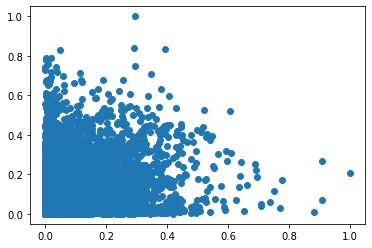

In [48]:
#plt.scatter(data['count_cd8_t_cell'],data['count_cdc1'])
plt.scatter(data['count_cd8_t_cell'],data['count_cd163_pos_haldr_neg'])

In [131]:
from sklearn.cluster import KMeans

,Cyclone Clustering,in_tumor.1
0,HLA-DR- tumor,0
1,HLA-DR- tumor,0
2,HLA-DR- tumor,0
3,HLA-DR- tumor,0
4,CD8 T cell,0
...,...,...
45173,Other,0
45174,Other,0
45175,Other,0
45176,Other,0


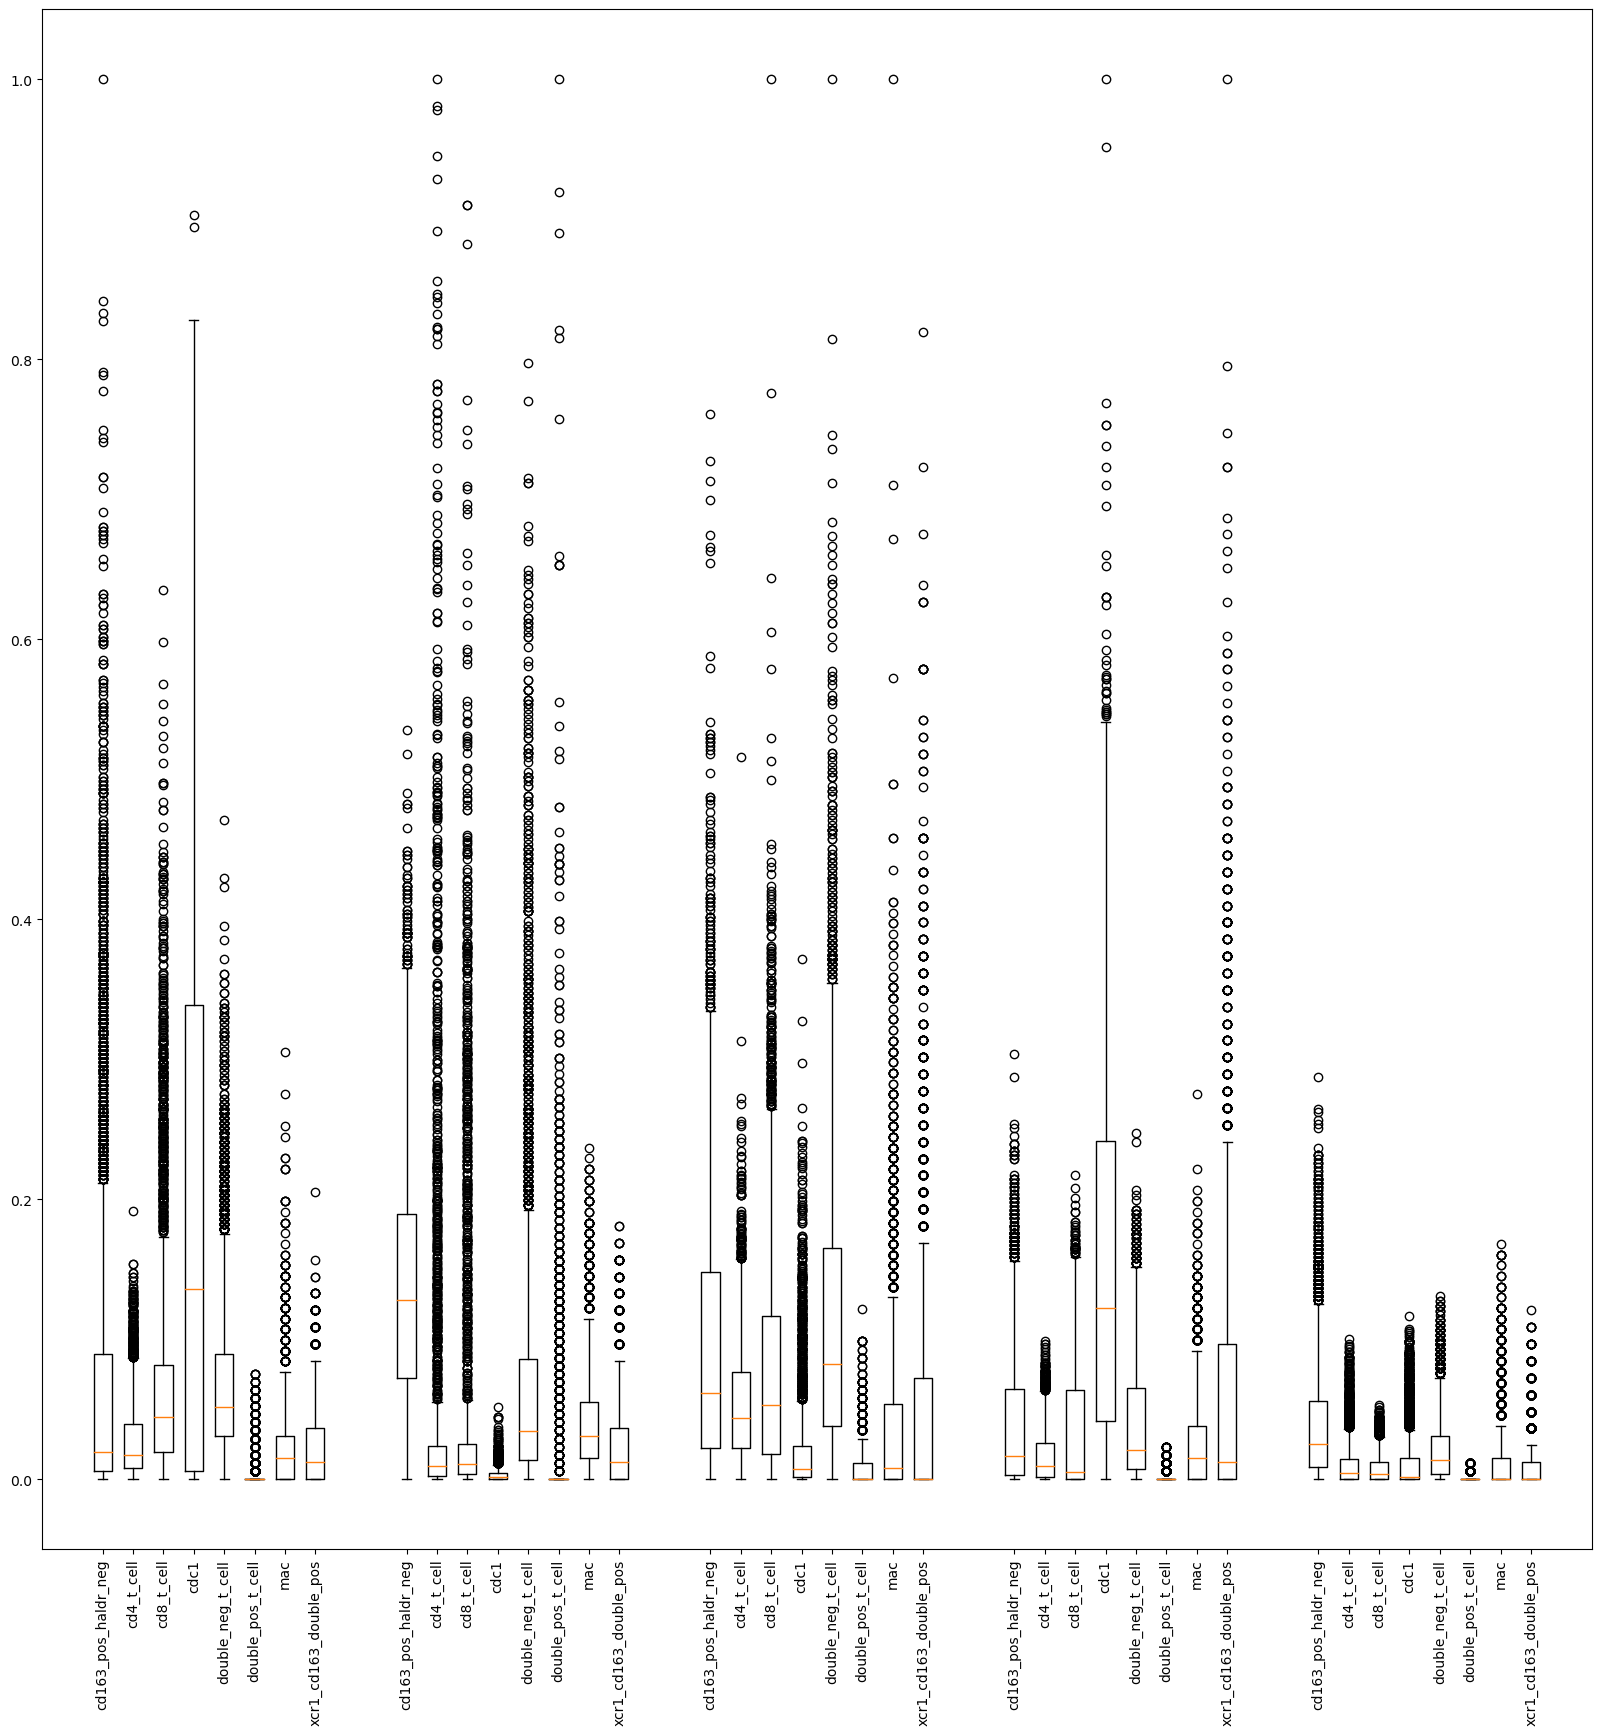

In [86]:
y = gmm.predict(data)

data['cluster']=y

x = 0
bar_width = 0.25

f = plt.figure(figsize=(20,20))
xtick_labels = []
xtick_pos = []
for c in np.unique(y):
    
    d = data[data['cluster']==c]
    
    
    for ct in cell_types:
        if ct in ['other','other_myeloid_and_b_cells']:continue
        
        xtick_labels.append(ct)
        xtick_pos.append(x)
        plt.boxplot(x=d['count_'+ct], positions=[x])
        x+=bar_width
    x+=bar_width*2
plt.xticks(xtick_pos, xtick_labels, rotation='vertical')
plt.show()

In [241]:
import seaborn as sb
from seaborn import kdeplot as kde

idx1 = ~np.isnan(z1)
z1=z1[idx1]

idx2 = ~np.isnan(z2)
z2=z2[idx2]
kde(z1)
kde(z2)
#plt.hist(z1,alpha=0.4)
#plt.hist(z2,alpha=0.4)
#plt.hist(z2, bins=20)
plt.legend(['IPICRC048', 'IPICRC057'])
#frac_cd8 = results_df['fraction_cd4_t_cell'].values[idx]
#plt.scatter(frac_cd8, zs)

plt.xlabel('interactions / # of cd8_t_cells')

NameError: name 'z1' is not defined

(array([ 5., 13., 23., 72., 36., 40., 15., 20.,  9.,  6.,  1.,  0.,  2.,
         1.,  2.,  1.,  1.,  0.,  0.,  1.]),
 array([-3.41680671, -2.64778972, -1.87877273, -1.10975574, -0.34073876,
         0.42827823,  1.19729522,  1.96631221,  2.7353292 ,  3.50434618,
         4.27336317,  5.04238016,  5.81139715,  6.58041413,  7.34943112,
         8.11844811,  8.8874651 ,  9.65648208, 10.42549907, 11.19451606,
        11.96353305]),
 <BarContainer object of 20 artists>)

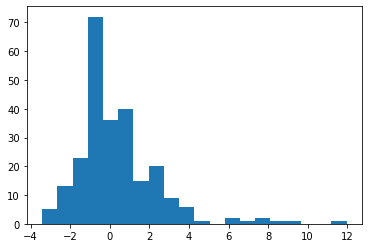

In [198]:
plt.hist(z2, bins=20)

In [61]:
df = pd.read_csv("/home/austin/Downloads/IPICRC072_manual_vs_cyclone_comparison.csv")

In [62]:
data = df[['Cyclone Clustering','in_tumor.1']]

stroma = data[data['in_tumor.1']==0]
tumor = data[data['in_tumor.1']==1]

In [77]:
stroma_counts = pd.DataFrame(data={'stroma':stroma['Cyclone Clustering'].value_counts()/stroma['Cyclone Clustering'].count()})
tumor_counts = pd.DataFrame(data={'tumor':tumor['Cyclone Clustering'].value_counts()/tumor['Cyclone Clustering'].count()})

AttributeError: 'DataFrame' object has no attribute 'sort'

<AxesSubplot:>

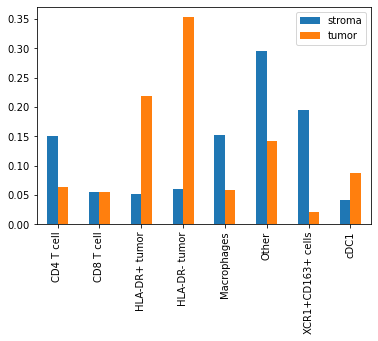

In [101]:
stroma_counts = stroma_counts.sort_index()
tumor_counts = tumor_counts.sort_index()
results = pd.concat([stroma_counts, tumor_counts],axis=1)

results.plot(kind='bar')


In [109]:
set(df['Cyclone Clustering'])

{'CD4 T cell',
 'CD8 T cell',
 'HLA-DR+ tumor',
 'HLA-DR- tumor',
 'Macrophages',
 'Other',
 'XCR1+CD163+ cells',
 'cDC1'}

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


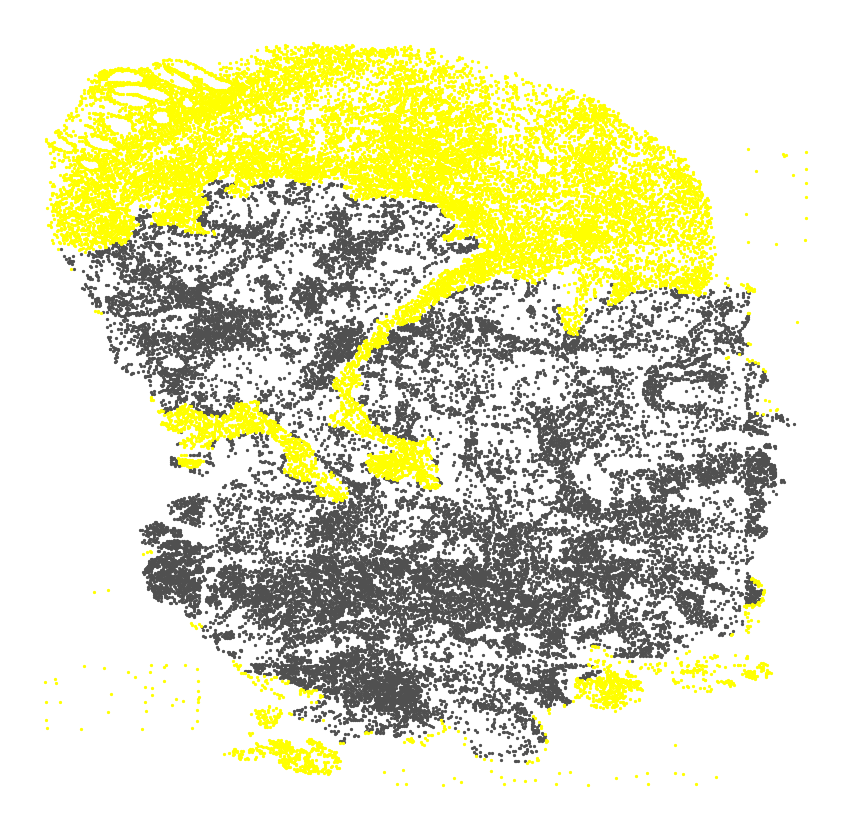

In [130]:
f = plt.figure(figsize=(15,15))
f.patch.set_facecolor('white')

tumor = df[df['in_tumor.1']==1]
stroma = df[df['in_tumor.1']==0]

plt.scatter(tumor['centroid-1'],-tumor['centroid-0'],c=(80/255,80/255,80/255),s=5)
plt.scatter(stroma['centroid-1'],-stroma['centroid-0'],c=(1,1,0),s=5)

#cd4 = df[df['Cyclone Clustering']=='cDC1']

#plt.scatter(cd4['centroid-1'],-cd4['centroid-0'],c=(0,1,1),s=5)
plt.axis('off')
plt.savefig(Path("/home/austin/data/IPI/IPICRC072_tumorstroma.png"),
            facecolor=f.get_facecolor(),
            bbox_inches='tight',
            transparent=False)

In [117]:
df['Cyclone Clustering']=='CD4 T Cell'

0        False
1        False
2        False
3        False
4        False
         ...  
45173    False
45174    False
45175    False
45176    False
45177    False
Name: Cyclone Clustering, Length: 45178, dtype: bool

In [118]:
set(df['Cyclone Clustering'])

{'CD4 T cell',
 'CD8 T cell',
 'HLA-DR+ tumor',
 'HLA-DR- tumor',
 'Macrophages',
 'Other',
 'XCR1+CD163+ cells',
 'cDC1'}